Task 1 (0.5 mark): Use the MeanShift algorithm for image segmentation.
Hint: Use MeanShift clustering from Scikit-learn.

Step 1. Once you have read the image into Numpy arrays, extract each colour channel (R, G, B) so you can use each as a variable for classification. To do this you will need to convert the colour matrices into a flattened vector as depicted below.

Step 2. Then you can use the new flattened colour sample matrix (e.g. 10,000 x 3 if your original image was 100 x 100) as your variable for classification.

Step 3. Use the MeanShift fit_predict() function to perform a clustering and save the cluster labels, which we want to observe.
Show the segmented image.

In [1]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MeanShift
import sklearn

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


In [2]:
def calculate_DSC(im1, im2):
    n = np.count_nonzero(im1 & im2)
    a = np.count_nonzero(im1)
    b = np.count_nonzero(im2)
    return 2 * n / (a + b)

number of estimated clusters : 7


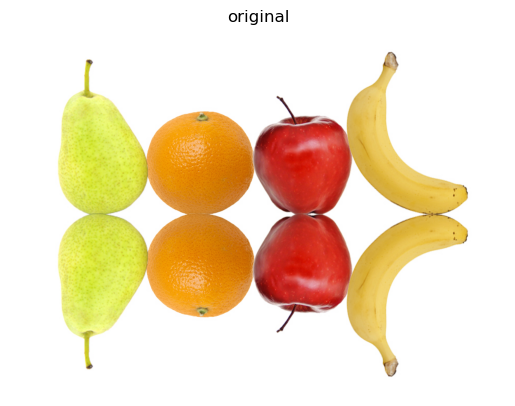

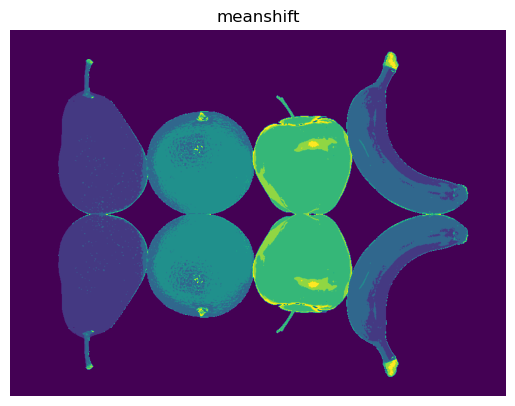

In [10]:
# Load file
file = 'Fruits.png'
img = cv.imread(file, cv.IMREAD_COLOR)
# make img 100x100
#img = cv.resize(img, (100,100))

h, w, _ = img.shape

# Split image into color channels
# and stack into flattened vector
b, g, r = cv.split(img)
b = b.flatten()
g = g.flatten()
r = r.flatten()
arr = np.vstack([b,g,r]).T

# create meanshift clustering classifier
bandwidth = sklearn.cluster.estimate_bandwidth(arr, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

# fit the meanshift classifier to the colour samples
ms_labels = ms.fit_predict(arr)

# some data
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(ms_labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

#Reshape labels to display
ms_labels_disp = ms_labels.reshape(h, w)

#plot images
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('original')
plt.imshow(cv.cvtColor(img, cv.COLOR_RGB2BGR))
plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('meanshift')
plt.imshow(ms_labels_disp)


Task 2 (1 mark): Use Watershed transformation for image segmentation.

Text(0.5, 1.0, 'Separated objects')

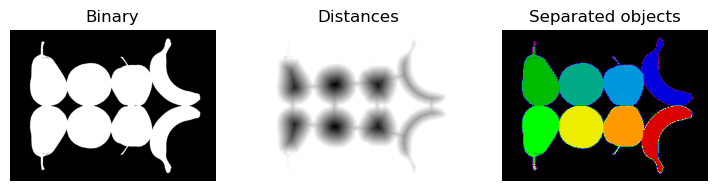

In [4]:
# convert to gray
img_grey = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
# Threshold image
ret, img_bin =cv.threshold(img_grey,240,255,cv.THRESH_BINARY)
img_bin = cv.bitwise_not(img_bin)

# Use watershed transformation (plot result of distance transform)
# Step 2 - Calculate the distance transform
distance = ndi.distance_transform_edt(img_bin)
coords = peak_local_max(distance, footprint=np.ones((100,100)), labels=img_bin)

#generate watershed markers
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
ws_labels = watershed(-distance, markers, mask=img_bin)

#plot images
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(0,3):
    ax[i].axis('off')

ax[0].imshow(img_bin, cmap=plt.cm.gray)
ax[0].set_title('Binary')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(ws_labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')



Task 3 (1 mark): Compare MeanShift and Watershed segmentation results.


In [5]:
# Given segments which are already binary and the correct mask
def calculate_JSC(image,mask):
    # Calculate the intersection and union of the binary masks
    intersection = np.logical_and(image,mask)
    union = np.logical_or(image,mask)

    # Calculate the Jaccard Similarity Coefficient (JSC)
    jsc = intersection.sum() / float(union.sum())
    # print(jsc)
    # print("-----------------")
    return jsc

#List of strings
MaskX = ['Mask{}.png'.format(str(idx)) for idx in range(1,8)]

# Get a list of masks for each segment for ms
ms_list = [np.array(ms_labels == i) for i in range(8)]

# Get a list of masks for each segment for watershed
ws_unique = np.unique(ws_labels)
ws_list = [np.array(ws_labels == i).flatten() for i in ws_unique]

# For each mask find the JSCs and print
for mask_name in MaskX:
    # load the image
    maskimg = cv.imread(mask_name,cv.IMREAD_GRAYSCALE)
    #reshape to be flat
    maskimg = maskimg.flatten()

    ms_jsc = [calculate_JSC(mask,maskimg) for mask in ms_list]
    ms_jsc = max(ms_jsc)

    ws_jsc = [calculate_JSC(mask,maskimg) for mask in ws_list]
    ws_jsc = max(ws_jsc)

    print(f'[{mask_name}]  |  Meanshift: {ms_jsc:.4f}  |  Watershed: {ws_jsc:.4f}')







[Mask1.png]  |  Meanshift: 0.3862  |  Watershed: 0.9791
[Mask2.png]  |  Meanshift: 0.4183  |  Watershed: 0.9918
[Mask3.png]  |  Meanshift: 0.4505  |  Watershed: 0.9905
[Mask4.png]  |  Meanshift: 0.2678  |  Watershed: 0.9898
[Mask5.png]  |  Meanshift: 0.3850  |  Watershed: 0.9766
[Mask6.png]  |  Meanshift: 0.4185  |  Watershed: 0.9918
[Mask7.png]  |  Meanshift: 0.4511  |  Watershed: 0.9918


It appears that watershed method has performed much better than the meanshifting method.
Being able to tune the kernel for the watershed has led to significantly better results.

A pre processing sugggestion can be adding a low-pass filter or image smoothing to the image may allow the meanshifting method to be better as the colour will be more similar which will allow less classes to be defined. It appears that there are too many classes generated due to the fine details on the fruit.
Post operations could include basin merging which can further increase accuracy of the watershed method